# Оцениваем регрессии на данных HS0 в спецификациях:
- Фиксированные эффекты ~ ковид и ограничения
- Фиксированные эффекты ~ ковид и ограничения | инструментальные переменные
- В перспективе: суммарный экспорт/импорт в зависимости от ковида (+ IV)

In [1]:
library(arrow)
library(stargazer)
library(tidyverse)
library(plotly)
library(fixest)


Присоединяю пакет: 'arrow'


Следующий объект скрыт от 'package:utils':

    timestamp



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Warning message:
"пакет 'tidyverse' был собран под R версии 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"пакет 'plotly' был собран под R версии 4.4.2"

Присоеди

## Фиксированные эффекты

### Экспорт

+иллюстрирую, зачем тут нужны фиксированные эффекты

In [2]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../../data/processed_data/trade_hs0_export_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,value,country:r,t,cases,deaths,tests,C1M_School_closing,C2M_Workplace_closing,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2020,SLV,-3.339168,SLV,2020,19.6259116,0.57060773,NA,2.426229,1.4344262,⋯,11.0,24.14867,17.73575,SLV,3.92,8.46,36.01,37.84,2020,0
2022,ASM,7.347834,ASM,2022,467.6200274,1.92600000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2022,0
2020,BOL,-5.962379,BOL,2020,35.1308840,2.07754144,NA,2.418033,1.8306011,⋯,21.0,22.42107,41.25143,BOL,3.53,20.34,34.82,27.64,2020,0
2020,SLE,1.653766,SLE,2020,0.8507182,0.02530387,NA,1.606557,0.2349727,⋯,80.3,35.38844,15.18978,SLE,5.29,6.42,20.52,33.28,2020,0
2020,LKA,-14.478386,LKA,2020,4.9664917,0.02309392,NA,1.931694,0.5546448,⋯,6.0,14.93368,NA,NA,NA,NA,NA,NA,2020,0
2022,ATG,13.013159,ATG,2022,143.9042740,0.82619178,NA,NA,NA,⋯,8.1,NA,NA,NA,NA,NA,NA,NA,2022,0


### Рисую обычный и demeaned scatterplot, чтобы обосновать необходимость использования фиксированных эффектов

Графики будут интерактивные, если раскомментить ggplotly, закомментить p и перепрогнать

Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`)."


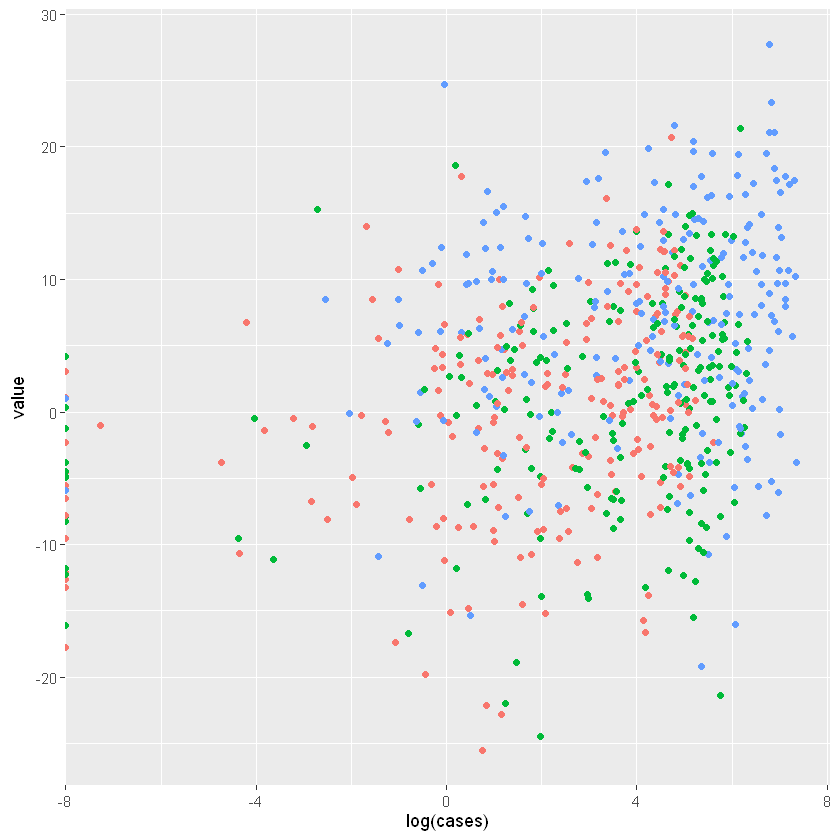

In [3]:
p = ggplot(df, aes(x = log(cases), y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p) 
p   

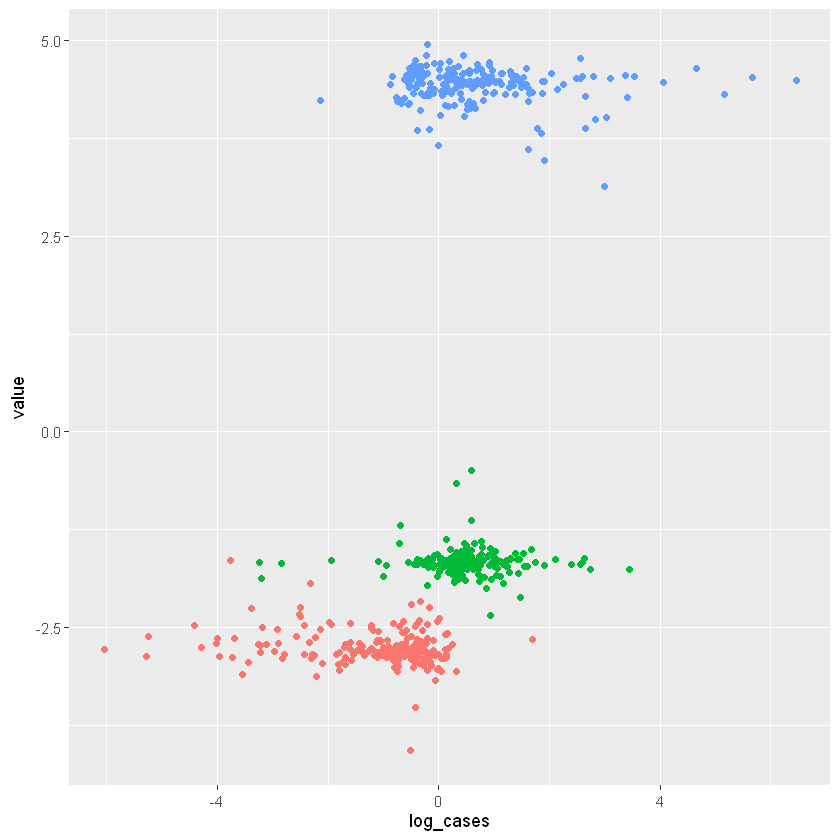

In [4]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_cases = mean(log(cases), na.rm = TRUE))  %>% filter(avg_log_cases > -1000)

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(log_cases = log(cases)- avg_log_cases, value = value- avg_value) %>%
   select(country, year, log_cases, value)
p = ggplot(demeaned_df, aes(x = log_cases, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

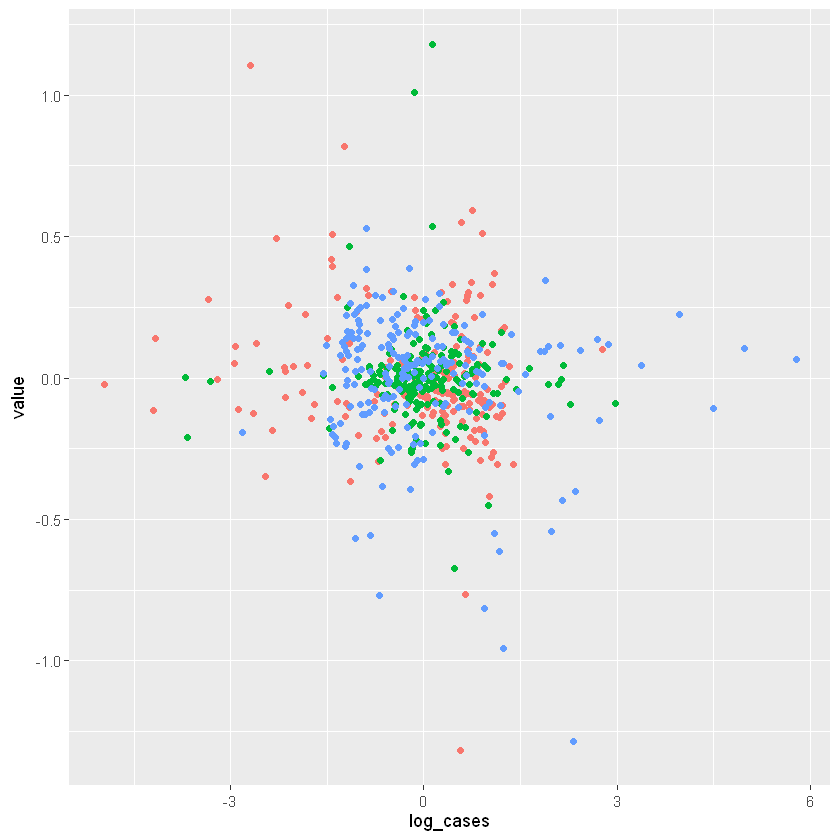

In [5]:
year_means_df = demeaned_df %>% filter(log_cases > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_cases = mean(log_cases, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(log_cases = log_cases- avg_log_cases, value = value - avg_value) %>%
   select(country, year, log_cases, value)

p = ggplot(demeaned_df2, aes(x = log_cases, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

In [6]:
year_means_df

year,avg_value,avg_log_cases
<chr>,<dbl>,<dbl>
2020,-2.752748,-1.0799770
2021,-1.667404,0.4683864
2022,4.420130,0.6776799


### Сами регрессии

In [7]:
# Pulled OLS
export_m0 = feols(value ~ log(cases) +
 C8EV_International_travel_controls| year,
 data = df)
export_m0 %>% summary(vcov = ~country)

NOTE: 139 observations removed because of NA and infinite values (RHS: 139).



OLS estimation, Dep. Var.: value
Observations: 521
Fixed-effects: year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value   Pr(>|t|)
log(cases)                          0.848212   0.218497  3.882035 0.00014688
C8EV_International_travel_controls -0.050219   0.646687 -0.077655 0.93819158
                                      
log(cases)                         ***
C8EV_International_travel_controls    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.51242     Adj. R2: 0.190029
                Within R2: 0.064397

In [8]:
export_m1 = feols(value ~ log(cases) +
 C8EV_International_travel_controls| country + year,
 data = df)
export_m1 %>% summary(vcov = ~country)

NOTE: 139 observations removed because of NA and infinite values (RHS: 139).



OLS estimation, Dep. Var.: value
Observations: 521
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value Pr(>|t|)    
log(cases)                         -0.007038   0.009333 -0.754089 0.451815    
C8EV_International_travel_controls -0.062528   0.027495 -2.274181 0.024176 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.168936     Adj. R2: 0.999382
                 Within R2: 0.021597

In [ ]:
export_m1_iv = feols(value ~ 1 + C8EV_International_travel_controls|country + year|
 log(cases) ~ #H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
export_m1_iv %>% summary(vcov = ~country)

NOTE: 141 observations removed because of NA and infinite values (RHS: 126, IV: 35/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(cases)
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 519
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error  t value Pr(>|t|)    
fit_log(cases)                     -0.042348   0.025484 -1.66178 0.098357 .  
C8EV_International_travel_controls -0.073744   0.027924 -2.64087 0.009022 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.173337     Adj. R2:  0.999347
                 Within R2: -0.02717 
F-test (1st stage), log(cases): stat = 25.6    , p = 2.025e-15, on 3 and 512 DoF.
                    Wu-Hausman: stat =  2.56056, p = 0.110491 , on 1 and 339 DoF.
                        Sargan: stat =  2.58727, p = 0.274272 , on 2 DoF.

In [10]:
# Гетерогенность во времени
export_m2 = feols(value ~ year/log(cases) + year/C8EV_International_travel_controls| country,
 data = df)
export_m2 %>% summary(vcov = ~country)

NOTE: 139 observations removed because of NA and infinite values (RHS: 139).



OLS estimation, Dep. Var.: value
Observations: 521
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                                             Estimate Std. Error   t value
year2021                                     0.978040   0.090260 10.835814
year2022                                     7.018722   0.113267 61.966094
year2020:log(cases)                         -0.019319   0.011731 -1.646787
year2021:log(cases)                         -0.007983   0.012367 -0.645521
year2022:log(cases)                          0.003302   0.010599  0.311530
year2020:C8EV_International_travel_controls -0.080936   0.040766 -1.985362
year2021:C8EV_International_travel_controls -0.035906   0.030117 -1.192187
year2022:C8EV_International_travel_controls -0.053719   0.060003 -0.895274
                                             Pr(>|t|)    
year2021                                    < 2.2e-16 ***
year2022                                    < 2.2e-16 ***
year2020:log(cases)               

In [11]:
# Здесь это точно не осмысленно использовать кластеризацию по годам.
# С кластеризацией по странам есть значимость только у ограничений на поездки. 
# На инструменты пока смотреть не стоит, потому что они слабые.
etable(export_m0, export_m1, export_m1_iv, export_m2, vcov = ~country)

,,export_m0,export_m1,export_m1_iv,export_m2
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(cases),0.8482*** (0.2185),-0.0070 (0.0093),-0.0423. (0.0255),
4,C8EV_International_travel_controls,-0.0502 (0.6467),-0.0625* (0.0275),-0.0737** (0.0279),
5,year2021,,,,0.9780*** (0.0903)
6,year2022,,,,7.019*** (0.1133)
7,year2020 x log(cases),,,,-0.0193 (0.0117)
8,year2021 x log(cases),,,,-0.0080 (0.0124)
9,year2022 x log(cases),,,,0.0033 (0.0106)


In [12]:
# С НАС ничего не значимо
etable(export_m0, export_m1, export_m1_iv, export_m2, vcov = vcov_NW(unit = 'country', time = 'year'))

,,export_m0,export_m1,export_m1_iv,export_m2
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(cases),0.8482. (0.2121),-0.0070 (0.0093),-0.0423 (0.0266),
4,C8EV_International_travel_controls,-0.0502 (0.7213),-0.0625 (0.0302),-0.0737 (0.0301),
5,year2021,,,,0.9780** (0.0953)
6,year2022,,,,7.019*** (0.1076)
7,year2020 x log(cases),,,,-0.0193 (0.0113)
8,year2021 x log(cases),,,,-0.0080 (0.0138)
9,year2022 x log(cases),,,,0.0033 (0.0106)


In [13]:
# Реплицирую (Berthou, 2024), но результат не сходится, если использовать ошибки НАС
m = feols(value ~ StringencyIndex_Average | country + year,
 data = df)
m %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))
m %>% summary(vcov = ~country)

NOTE: 126 observations removed because of NA values (RHS: 126).



OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Newey-West (L=1) 
                         Estimate Std. Error  t value Pr(>|t|) 
StringencyIndex_Average -0.003248   0.001156 -2.80962  0.10677 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.16986     Adj. R2: 0.999378
                Within R2: 0.020902

OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error  t value  Pr(>|t|)    
StringencyIndex_Average -0.003248   0.001159 -2.80255 0.0056352 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.16986     Adj. R2: 0.999378
                Within R2: 0.020902

### Импорт

In [14]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../../data/processed_data/trade_hs0_import_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,value,country:r,t,cases,deaths,tests,C1M_School_closing,C2M_Workplace_closing,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2020,SLV,5.593365,SLV,2020,19.6259116,0.57060773,NA,2.426229,1.4344262,⋯,11.0,24.14867,17.73575,SLV,3.92,8.46,36.01,37.84,2020,0
2022,ASM,11.366298,ASM,2022,467.6200274,1.92600000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2022,0
2020,BOL,-4.466964,BOL,2020,35.1308840,2.07754144,NA,2.418033,1.8306011,⋯,21.0,22.42107,41.25143,BOL,3.53,20.34,34.82,27.64,2020,0
2020,SLE,-1.079447,SLE,2020,0.8507182,0.02530387,NA,1.606557,0.2349727,⋯,80.3,35.38844,15.18978,SLE,5.29,6.42,20.52,33.28,2020,0
2020,LKA,11.645198,LKA,2020,4.9664917,0.02309392,NA,1.931694,0.5546448,⋯,6.0,14.93368,NA,NA,NA,NA,NA,NA,2020,0
2022,ATG,-10.549667,ATG,2022,143.9042740,0.82619178,NA,NA,NA,⋯,8.1,NA,NA,NA,NA,NA,NA,NA,2022,0


In [15]:
# Реплицирую (Berthou, 2024), но результат совсем не сходится...
m = feols(value ~ StringencyIndex_Average | country + year,
 data = df)
m %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))
m %>% summary(vcov = ~country)

NOTE: 126 observations removed because of NA values (RHS: 126).



OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Newey-West (L=1) 
                         Estimate Std. Error  t value Pr(>|t|) 
StringencyIndex_Average -0.002699   0.001079 -2.50267  0.12939 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141099     Adj. R2: 0.999541
                 Within R2: 0.020914

OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error  t value Pr(>|t|)    
StringencyIndex_Average -0.002699   0.001101 -2.45075 0.015228 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141099     Adj. R2: 0.999541
                 Within R2: 0.020914

### Обосновываю включение фиксированных эффектов

In [16]:
fixest::demean(df[, c('cases', 'value')], df[, c('country', 'year')]) %>% head()

NOTE: 6 observations removed because of NA values (Breakup: X: 6, f: 0).



cases,value
<dbl>,<dbl>
114.00370,-0.17822285
153.51594,-0.21494329
72.09498,-0.05014374
123.76607,0.10634113
101.85724,0.21114565
-103.69409,0.14120842


Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`)."


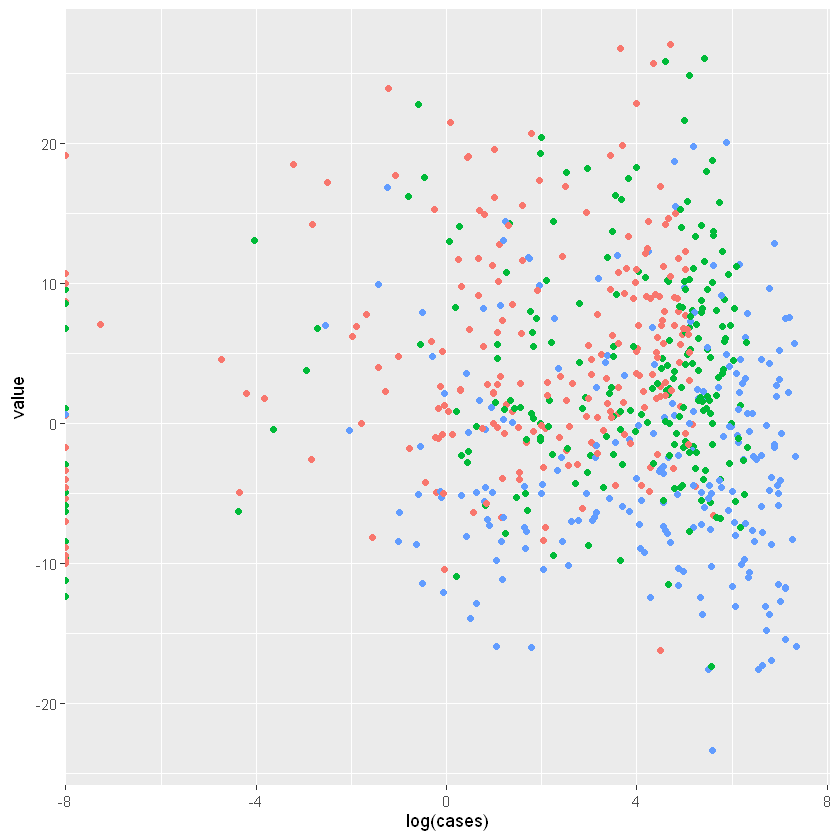

In [17]:
p = ggplot(df, aes(x = log(cases), y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)   
p 

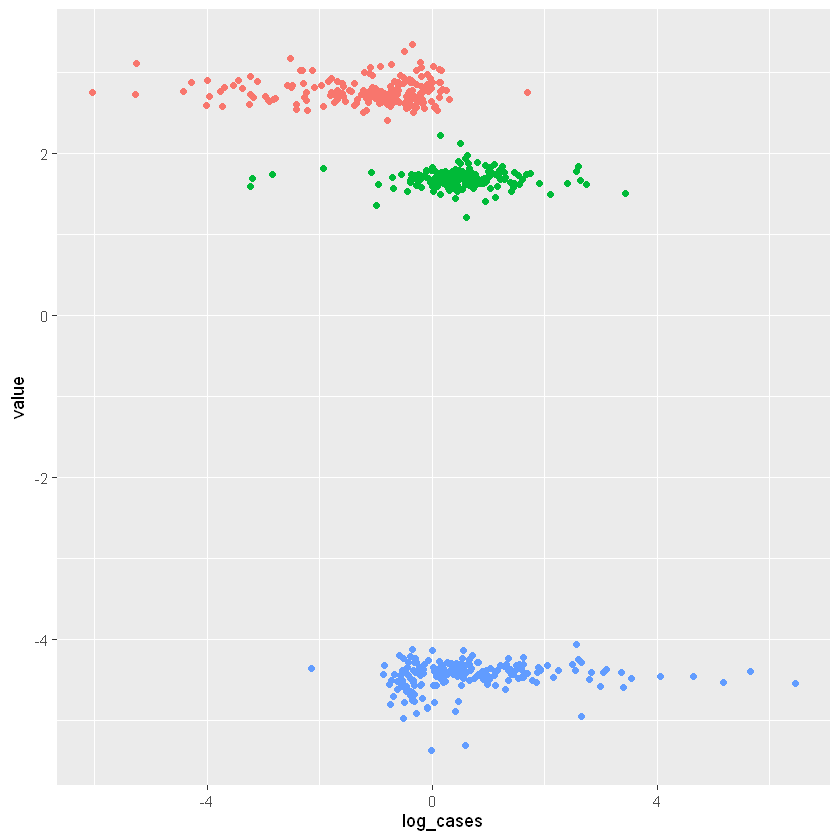

In [18]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_cases = mean(log(cases), na.rm = TRUE))  %>% filter(avg_log_cases > -1000)

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(log_cases = log(cases)- avg_log_cases, value = value- avg_value) %>%
   select(country, year, log_cases, value)
p = ggplot(demeaned_df, aes(x = log_cases, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)  
p  

In [19]:
year_means_df

year,avg_value,avg_log_cases
<chr>,<dbl>,<dbl>
2020,-2.752748,-1.0799770
2021,-1.667404,0.4683864
2022,4.420130,0.6776799


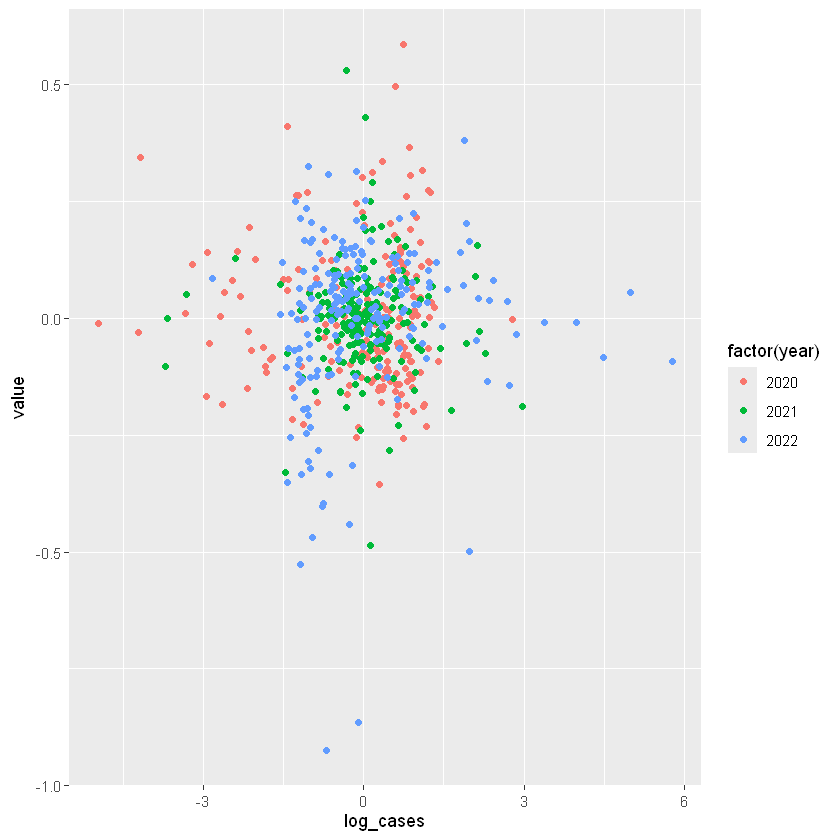

In [20]:
year_means_df = demeaned_df %>% filter(log_cases > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_cases = mean(log_cases, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(log_cases = log_cases- avg_log_cases, value = value - avg_value) %>%
   select(country, year, log_cases, value)

p = ggplot(demeaned_df2, aes(x = log_cases, y = value, text = factor(country), color = factor(year)
    )) + geom_point()#+ theme(legend.position = "none")
# ggplotly(p)   
p 

### Сами регрессии

In [21]:
# Pulled OLS
import_m0 = feols(value ~ log(cases) +
 C8EV_International_travel_controls| year,
 data = df)
import_m0 %>% summary(vcov = ~country)

NOTE: 139 observations removed because of NA and infinite values (RHS: 139).



OLS estimation, Dep. Var.: value
Observations: 521
Fixed-effects: year: 3
Standard-errors: Clustered (country) 
                                   Estimate Std. Error  t value Pr(>|t|) 
log(cases)                         0.031419   0.223268 0.140725  0.88825 
C8EV_International_travel_controls 0.713550   0.769504 0.927286  0.35506 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.39765     Adj. R2: 0.15667 
                Within R2: 0.003359

In [22]:
import_m1 = feols(value ~ log(cases) +
 C8EV_International_travel_controls| country + year,
 data = df)
import_m1 %>% summary(vcov = ~country)

NOTE: 139 observations removed because of NA and infinite values (RHS: 139).



OLS estimation, Dep. Var.: value
Observations: 521
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value Pr(>|t|) 
log(cases)                          0.001900   0.007616  0.249432  0.80332 
C8EV_International_travel_controls -0.032755   0.020467 -1.600389  0.11133 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.142679     Adj. R2: 0.999527
                 Within R2: 0.008703

In [23]:

import_m1_iv = feols(value ~ 1 +
 C8EV_International_travel_controls|country + year|
 log(cases) ~  C1M_School_closing+median_age+population_density,
 data = df)
import_m1_iv %>% summary(vcov = ~country)

NOTE: 141 observations removed because of NA and infinite values (RHS: 126, IV: 35/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(cases)
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 519
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value Pr(>|t|)    
fit_log(cases)                     -0.004139   0.025942 -0.159556 0.873416    
C8EV_International_travel_controls -0.034439   0.019698 -1.748366 0.082164 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.143035     Adj. R2: 0.999522
                 Within R2: 0.006428
F-test (1st stage), log(cases): stat = 25.6     , p = 2.025e-15, on 3 and 512 DoF.
                    Wu-Hausman: stat =  0.106867, p = 0.743942 , on 1 and 339 DoF.
                        Sargan: stat =  0.838753, p = 0.657457 , on 2 DoF.

In [24]:
# Гетерогенность во времени
import_m2 = feols(value ~ year/log(cases) + year/C8EV_International_travel_controls| country,
 data = df)
import_m2 %>% summary(vcov = ~country)

NOTE: 139 observations removed because of NA and infinite values (RHS: 139).



OLS estimation, Dep. Var.: value
Observations: 521
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                                             Estimate Std. Error    t value
year2021                                    -1.212015   0.078992 -15.343596
year2022                                    -7.306150   0.114756 -63.666960
year2020:log(cases)                         -0.012978   0.009892  -1.311999
year2021:log(cases)                          0.004933   0.010398   0.474403
year2022:log(cases)                          0.019971   0.008517   2.344937
year2020:C8EV_International_travel_controls -0.024784   0.032070  -0.772791
year2021:C8EV_International_travel_controls  0.018529   0.017197   1.077429
year2022:C8EV_International_travel_controls -0.086923   0.071303  -1.219058
                                             Pr(>|t|)    
year2021                                    < 2.2e-16 ***
year2022                                    < 2.2e-16 ***
year2020:log(cases)      

In [25]:
# Для импортёра вообще ничто не значимо.
etable(import_m0, import_m1, import_m1_iv, import_m2, vcov = ~country)

,,import_m0,import_m1,import_m1_iv,import_m2
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(cases),0.0314 (0.2233),0.0019 (0.0076),-0.0041 (0.0259),
4,C8EV_International_travel_controls,0.7135 (0.7695),-0.0328 (0.0205),-0.0344. (0.0197),
5,year2021,,,,-1.212*** (0.0790)
6,year2022,,,,-7.306*** (0.1148)
7,year2020 x log(cases),,,,-0.0130 (0.0099)
8,year2021 x log(cases),,,,0.0049 (0.0104)
9,year2022 x log(cases),,,,0.0200* (0.0085)


In [26]:
etable(import_m0, import_m1, import_m1_iv, import_m2, vcov = vcov_NW(unit = 'country', time = 'year'))

,,import_m0,import_m1,import_m1_iv,import_m2
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(cases),0.0314 (0.2100),0.0019 (0.0076),-0.0041 (0.0261),
4,C8EV_International_travel_controls,0.7135 (0.8180),-0.0328 (0.0223),-0.0344 (0.0211),
5,year2021,,,,-1.212** (0.0828)
6,year2022,,,,-7.306*** (0.1063)
7,year2020 x log(cases),,,,-0.0130 (0.0094)
8,year2021 x log(cases),,,,0.0049 (0.0111)
9,year2022 x log(cases),,,,0.0200 (0.0084)


## Суммарный экспорт/импорт